In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

## 导入数据以及数据概览

In [4]:
#导入users.dat文件
#为这个dat文件中每一列取相应的名字
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
#导入movies.dat文件
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
##导入ratings.dat文件
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 数据预处理

In [7]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #处理表示用户性别的变量Gender
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)
    #处理表示用户年龄的变量Age
    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values

    #电影类型变量Genres转数字字典
    genres_set = set()
    #原文件中若一部电影有多个风格，使用的|作为并列符号，所以分离时split('|')
    for val in movies['Genres'].str.split('|'): 
        genres_set.update(val)
    #空白部分用‘< PAD >’对应的数字进行填充，这样方便将长度统一，之后有利于在神经网络中进行处理。
    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型变量Genres转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    movies['Genres'] = movies['Genres'].map(genres_map)

    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')#利用正则表达式去掉title中的年份信息
    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)
    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    #空白部分用‘< PAD >’对应的数字进行填充，这样方便将长度统一，之后有利于在神经网络中进行处理。
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}
    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    movies['Title'] = movies['Title'].map(title_map)

    #读取rating.dat文件
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    #合并三个dat表，方便后续进行处理
    data = pd.merge(pd.merge(ratings, users), movies)
    #将数据分成X(已有的所有特征)和y(目标变量rating)两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    features = features_pd.values      #这是所有的特征值
    targets_values = targets_pd.values #这是目标变量rating值
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [8]:
#运行上方的对数据进行预处理的函数load_data()
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()
pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

### 查看预处理后的数据

In [9]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [10]:
movies.head()

,MovieID,Title,Genres
0,1,"[2936, 4367, 4037, 4037, 4037, 4037, 4037, 403...","[11, 16, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
1,2,"[4796, 4037, 4037, 4037, 4037, 4037, 4037, 403...","[8, 16, 5, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
2,3,"[5063, 1553, 2868, 4037, 4037, 4037, 4037, 403...","[3, 7, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
3,4,"[140, 3577, 5102, 4037, 4037, 4037, 4037, 4037...","[3, 18, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
4,5,"[4117, 32, 1412, 618, 3980, 3217, 4037, 4037, ...","[3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."


In [11]:
movies.values[0]

array([1,
       list([2936, 4367, 4037, 4037, 4037, 4037, 4037, 4037, 4037, 4037, 4037, 4037, 4037, 4037, 4037]),
       list([11, 16, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
      dtype=object)

In [12]:
# 从本地读取数据
title_count, title_set, genres2int, features, targets_values,ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## 一些有关存储与读取的函数

In [13]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    将参数保存至文件params.p中
    """
    pickle.dump(params, open('params.p', 'wb'))

def load_params():
    """
    从params.p文件中加载数据
    """
    return pickle.load(open('params.p', mode='rb'))


## 设定和嵌入相关的固定数值

In [14]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21
#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216
#对电影类型嵌入向量做加和操作的标志
combiner = "sum"
#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8
#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参设置

In [15]:
# 训练的轮次数目 ：epoch的数目
num_epochs = 5
# Batch Size
batch_size = 256
#drop的大小，防止过拟合
dropout_keep = 0.5
# 学习率learning rate
learning_rate = 0.0001
# 设定每20个batch就显示一次输出
show_every_n_batches = 20
save_dir = './save'

### 输入

定义输入的占位符

In [16]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络

#### User的embedding：对应将有关用户的原始特征输入嵌入层的那一步骤

In [17]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        #uid_embed_matrix是一个被随即均匀随机数填充的维度是[uid_max, embed_dim]的张量
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        #在uid_embed_matrix的张量列表中执行并行查找，返回和uid_embed_matrix相同类型的tensor，这便是经过嵌入层后得到的userID向量
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        #对用户性别变量Gender执行同样操作
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        #对用户年龄变量Age执行同样操作
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        #对用户职业变量job执行同样操作
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 将和用户相关的embedding送入接下来的两层全连接层(FC)，训练得到用户特征向量

In [18]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接层，将通过get_user_embedding()得到的四个变量的嵌入矩阵分别送入第一层全连接层进行训练
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)#使用relu作为激活函数
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接，将上方从全连接层输出的四个变量的向量进行拼接(concat)之后送入第二层全连接层
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        #reshape：变化tensor的维度，使得到的用户特征向量与电影特征向量一致且正确
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

#### MovieID的embedding(嵌入矩阵)

In [19]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

#### 电影类型Genres的embedding(嵌入矩阵)

In [20]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1),
                                                    name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories,
                                                              name = "movie_categories_embed_layer")
        #对电影类型的多个嵌入向量做加和（因为一部电影的风格类型有多种，本实验采用加和的方式进行处理）
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    return movie_categories_embed_layer

In [ ]:
网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。
下一层使用多个不同尺寸（窗口大小）的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。
这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度），
比如每次滑动3个，4个或者5个单词。第三层网络是max pooling得到一个长向量，
最后使用dropout做正则化，最终得到了电影Title的特征。

#### 电影名称变量Title的文本卷积网络实现

In [21]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        #先得到嵌入矩阵embedding
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        #reshape改变其维度，将其展平
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    #文本卷积覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度）
    #对文本嵌入层使用不同尺寸的卷积核做卷积以及最大池化maxpooling
    pool_layer_lst = [] # 用来存放每次池化后的结果
    #window_sizes = {2, 3, 4, 5} 文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词  
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            #卷积核权重W
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            #卷积核偏置b
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            #卷积conv
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            #做一次relu
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            #maxpooling最大池化
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    # Dropout
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")#将pool_layer_lst中存放的四个结果拼接起来
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

#### 将上述的得到的和电影相关的三个变量的嵌入矩阵一起送入全连接层，得到电影特征向量

In [22]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接层  仍然使用relu作为激活函数
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接层
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        #重塑tenso的维度
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [23]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #用get_user_embedding获取User的4个嵌入向量，然后用get_user_feature_layer得到用户特征
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #用get_movie_id_embed_layer获取电影ID的嵌入向量，然后用get_movie_categories_layers获取电影类型的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量，然后得到电影特征
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,movie_categories_embed_layer,dropout_layer)
    #计算出评分rating，注意后期做推荐时，传入的inference有两个不同的值，因此这里会有两个不同的方案
    with tf.name_scope("inference"):
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1) #这里得到预测评分
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        cost = tf.losses.mean_squared_error(targets, inference )# MSE损失，将计算值回归到评分
        loss = tf.reduce_mean(cost)
        
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)#采用Adam优化算法，lr：学习率learning rate
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

## 取得batch

In [25]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime
losses = {'train':[], 'test':[]}
with tf.Session(graph=train_graph) as sess:
    #为使用可视化工具tensorBoard搜集数据
    grad_summaries = []# 用于保存过程中的梯度值
    #训练过程中，主要用到了tf.summary()的各类方法，能够保存训练过程以及参数分布图并在tensorboard显示
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
    # 确定好模型的输出与summaries的存储路径
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
    loss_summary = tf.summary.scalar("loss", loss)# 损失函数值
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])# 训练过程中的参数分布图
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):#前面的代码中确定了num_epoch也即训练的轮次=5
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,targets_values,test_size = 0.2,random_state = 0)
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]
            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]
            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step) 
            # 每show_every_n_batches个batch就输出一次，输出的格式类似于2021-12-26T12:20:59.208584: Epoch0 Batch0/3125train_loss = 21.708
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(time_str,epoch_i,batch_i,(len(train_X) // batch_size),train_loss))
        
        for batch_i  in range(len(test_X) // batch_size):#开始迭代进行测试
            x, y = next(test_batches)
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]
            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]
            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost
            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step) 
            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(time_str,epoch_i,batch_i,(len(test_X) // batch_size),test_loss))
    
    saver.save(sess, save_dir)  # 保存模型
    print('Model Trained and Saved')


Writing to /content/runs/1640521250

2021-12-26T12:20:59.208584: Epoch   0 Batch    0/3125   train_loss = 21.708
2021-12-26T12:20:59.997538: Epoch   0 Batch   20/3125   train_loss = 5.651
2021-12-26T12:21:00.779154: Epoch   0 Batch   40/3125   train_loss = 3.053
2021-12-26T12:21:01.560477: Epoch   0 Batch   60/3125   train_loss = 2.084
2021-12-26T12:21:02.292780: Epoch   0 Batch   80/3125   train_loss = 2.298
2021-12-26T12:21:03.057890: Epoch   0 Batch  100/3125   train_loss = 1.957
2021-12-26T12:21:03.813986: Epoch   0 Batch  120/3125   train_loss = 2.107
2021-12-26T12:21:04.574307: Epoch   0 Batch  140/3125   train_loss = 1.814
2021-12-26T12:21:05.338989: Epoch   0 Batch  160/3125   train_loss = 1.581
2021-12-26T12:21:06.074545: Epoch   0 Batch  180/3125   train_loss = 1.682
2021-12-26T12:21:06.841178: Epoch   0 Batch  200/3125   train_loss = 1.643
2021-12-26T12:21:07.593032: Epoch   0 Batch  220/3125   train_loss = 1.650
2021-12-26T12:21:08.375567: Epoch   0 Batch  240/3125   train_

## 在 TensorBoard 中查看可视化结果

- 这一步也可省略，因为用tensorboard展示出来的内容和下方的可视化类似，不过需要在本地下载tensoboard并且需要相应的版本
- 但是会更好看且可有交互，不过若想保存下来，则会失去交互效果，因此还是采用下方用matplotlib画图
- 终端中执行命令 tensorboard --logdir D:/by_CUC/dataMining/mltf/content/runs/1640521250/summaries 即可
- 方便起见，还是采用下方用matplotlib画图

## 保存参数

In [27]:
save_params((save_dir))#保存`save_dir` 在生成预测时使用。
load_dir = load_params()

## 显示训练Loss损失值

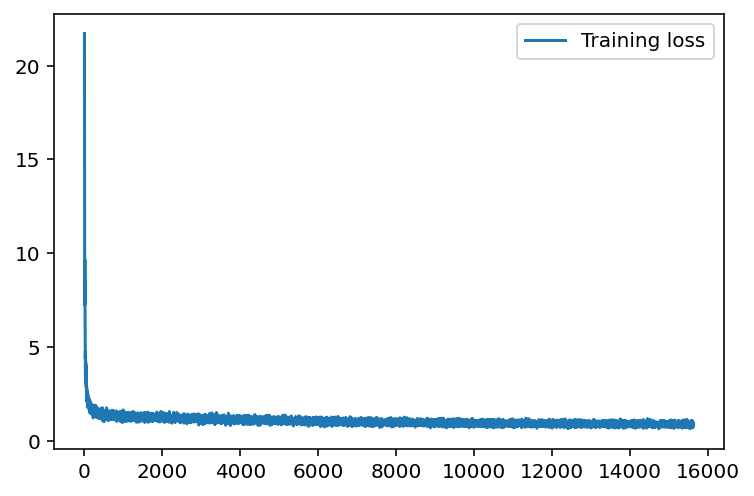

In [28]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss损失值

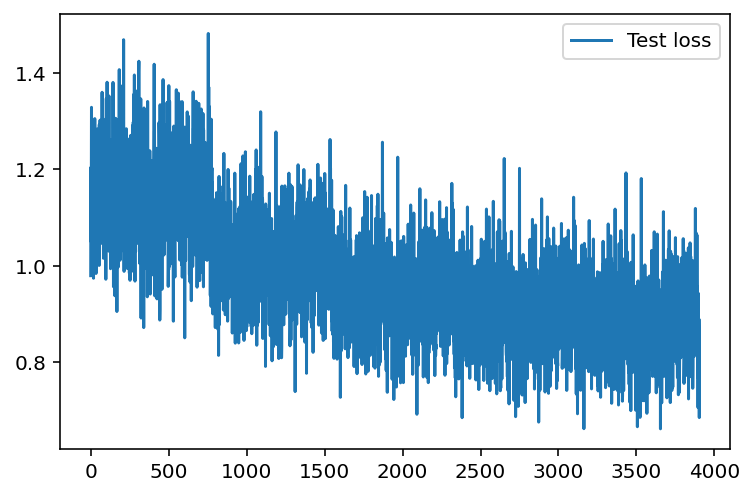

In [29]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 获取 Tensors
使用函数 [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name)从 `loaded_graph` 中获取tensors，后面的推荐功能要用到。

In [30]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0")
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat



##  从训练好的模型中得到预测评分

In [31]:
#可以理解为是网络的正向传播
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        loader = tf.train.import_meta_graph(load_dir + '.meta')#加载已经保存下来的训练好的模型
        loader.restore(sess, load_dir)
        # 从加载的模型中获取推荐需要的tensor
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
        # 得到预测的评分rating
        inference_val = sess.run([inference], feed)  
        return (inference_val)

In [32]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[3.2218027]], dtype=float32)]


### 将训练好的电影特征组合成电影特征矩阵并保存到本地movie_matrics.p文件中

In [33]:
# 将训练好的电影特征组合成电影特征矩阵并保存到本地movie_matrics.p文件
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess: 
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    # 从加载的模型中获取推荐需要的tensor
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph
    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)
        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)
        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}
        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)
#将学习得到的电影特征矩阵存入movie_matrics.p文件中
pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [34]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

### 将训练好的用户特征组合成用户特征矩阵并保存到本地users_matrics.p文件中

In [35]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    #从加载的模型中获取推荐需要的tensor
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph
    for item in users.values:
        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}
        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)
pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [36]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
先计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个,为了使得每次推荐的内容不会完全一致，因此加入了随机成分

In [37]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # 加载保存下来的模型
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        #先将整个电影特征矩阵模型进行归一化 ，是为了避免整体值太大
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics
        #计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        #取相似度最大的top_k个电影作为推荐的电影
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set() #用来存放最后要进行推荐的电影
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]#为了使得每次推荐的内容不会完全一致，因此加入了随即成分
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        return results

In [38]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
2689
[2758 'Plenty (1985)' 'Drama']
296
[299 'Priest (1994)' 'Drama']
392
[396 'Fall Time (1995)' 'Drama']
1098
[1114 'Funeral, The (1996)' 'Drama']
1658
[1706 'Harlem River Drive (1996)' 'Drama']


{296, 392, 1098, 1658, 2689}

### 推荐某个用户喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [39]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')# 加载已保存好的模型
        loader.restore(sess, load_dir)
        #推荐某个用户喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))#将两个特征矩阵相乘即可得到评分
        sim = (probs_similarity.eval())
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        return results

In [40]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
1122
[1138 'Dadetown (1995)' 'Documentary']
2274
[2343 'Naked Man, The (1998)' 'Drama']
3243
[3312 'McCullochs, The (1975)' 'Drama']
689
[698 'Delta of Venus (1994)' 'Drama']
1950
[2019
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{689, 1122, 1950, 2274, 3243}

### 喜欢看这个电影的人有哪些

In [41]:
import random
def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')# 加载已经保存好的模型
        loader.restore(sess, load_dir)
        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        #！！！注意这里为了得到针对每一部电影而言，每个用户对其的兴趣程度
        #！！！在计算相似度时，应当用电影特征矩阵×用户特征矩阵的转置
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))

In [43]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[3833 'M' 25 1]
 [2002 'F' 56 13]
 [5458 'F' 18 2]
 [1855 'M' 18 4]
 [1644 'M' 18 12]
 [5102 'M' 25 12]
 [4967 'M' 18 4]
 [2312 'M' 45 0]
 [4281 'M' 56 13]
 [1763 'M' 35 7]
 [2258 'F' 18 4]
 [1383 'F' 25 7]
 [100 'M' 35 17]
 [5728 'F' 35 20]
 [2154 'M' 25 12]
 [1701 'F' 25 4]
 [4800 'M' 18 4]
 [4438 'M' 50 0]
 [371 'M' 18 4]
 [4085 'F' 25 6]]

{1244, 1742, 1779, 1812, 2535}